<a href="https://colab.research.google.com/github/yanli499/ChatTime/blob/master/Recurrent_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchtext

# The first time you run this will download a ~823MB file
glove = torchtext.vocab.GloVe(name="6B", # trained on Wikipedia 2014 corpus
                              dim=50)   # embedding size = 50

In [0]:
#setup Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import csv

# file location (make sure to use your file location)
file_dir = '/content/drive/My Drive/Colab Notebooks/APS360 Project/'

# load csv file
def get_data():
    return csv.reader(open(file_dir + "training.1600000.processed.noemoticon.csv","rt", encoding="latin-1"))

# print only the first tweet
for i, line in enumerate(get_data()):
    if line[0] != '0':
        print(line[0], line[-1])
        break

4 I LOVE @Health4UandPets u guys r the best!! 


In [0]:
import torchtext
glove = torchtext.vocab.GloVe(name="6B", dim=50)

def split_tweet(tweet):
    # separate punctuations
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return tweet.lower().split()

In [0]:
# import torch
# import torch.nn as nn

# def get_tweet_vectors(glove_vector):
#     train, valid, test = [], [], []
#     for i, line in enumerate(get_data()):
#         tweet = line[-1]
#         if i % 59 == 0:
#             # obtain an embedding for the entire tweet
#             tweet_emb = sum(glove_vector[w] for w in split_tweet(tweet))
#             # generate a label: 1 = happy, 0 = sad
#             label = torch.tensor(int(line[0] == "4")).long()
#             # place the data set in either the training, validation, or test set
#             if i % 5 < 3:

#                 train.append((tweet_emb, label)) # 60% training
#             elif i % 5 == 4:
#                 valid.append((tweet_emb, label)) # 20% validation
#             else:
#                 test.append((tweet_emb, label)) # 20% test
#     return train, valid, test

In [0]:
# import torchtext

# glove = torchtext.vocab.GloVe(name="6B", dim=50)

# train, valid, test = get_tweet_vectors(glove)

# train_loader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
# valid_loader = torch.utils.data.DataLoader(valid, batch_size=128, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=True)

In [0]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
import numpy as np
import matplotlib.pyplot as plt

# file location (make sure to use your file location)
#file_dir = '/content/drive/My Drive/Colab Notebooks/'

def get_data():
    return csv.reader(open(file_dir + "training.1600000.processed.noemoticon.csv","rt", encoding="latin-1"))

def split_tweet(tweet):
    # separate punctuations
    tweet = tweet.replace(".", " . ") \
                 .replace(",", " , ") \
                 .replace(";", " ; ") \
                 .replace("?", " ? ")
    return tweet.lower().split()

glove = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=10000) # use 10k most common words

In [0]:
import pandas as pd

columns = ['label', 'text']
#columns = ['text']
df_train = pd.DataFrame(columns=columns)
df_val = pd.DataFrame(columns=columns)
df_test = pd.DataFrame(columns=columns)

In [0]:
def get_tweet_words(glove_vector):
    train, valid, test = [], [], []
    tr,vl,te = 0,0,0
    for i, line in enumerate(get_data()):
        if i % 29 == 0:
            tweet = line[-1]
            #print(tweet)
            idxs = [glove_vector.stoi[w]        # lookup the index of word
                    for w in split_tweet(tweet)
                    if w in glove_vector.stoi] # keep words that has an embedding
            if not idxs: # ignore tweets without any word with an embedding
                continue
            idxs = torch.tensor(idxs) # convert list to pytorch tensor
            label = torch.tensor(int(line[0] == "4")).long()
            label_panda = 'sdf'
            if (label.item() == 0):
                label_panda = 'neg'
            elif(label.item() == 1):
                label_panda = 'pos'

            if i % 5 < 3:
                s1 = [tweet, label.item()]
                df_train.loc[tr, 'text'] = tweet
                df_train.loc[tr, 'label'] = label_panda #label.item()
                tr+=1
                train.append((idxs, label))
            elif i % 5 == 4:
                s1 = [tweet, label.item()]
                df_val.loc[vl, 'text'] = tweet
                df_val.loc[vl, 'label'] = label_panda#label.item()           
                vl+=1          
                valid.append((idxs, label))
            else:
                s1 = [tweet, label.item()]
                df_test.loc[te, 'text'] = tweet
                df_test.loc[te, 'label'] = label_panda#label.item()
                te+=1           
                test.append((idxs, label))
    return train, valid, test

train, valid, test = get_tweet_words(glove)


In [0]:
print(train[0])

(tensor([   2,   11,    1,    7,    2,   81,  405,  684, 9912,    3,  245,  122,
           4,   88,   20,    2,   89, 1968]), tensor(0))


In [0]:
df_train[:3]

,label,text
0,neg,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,neg,My tummy hurts. I wonder if the hypnosis has ...
2,neg,@HibaNick yeah aw but i know i wudnt stand a c...


In [0]:
# glove_emb = nn.Embedding.from_pretrained(glove.vectors) #this might be why we were getting that error

# # Example: we use the forward function of glove_emb to lookup the
# # embedding of each word in `tweet`
# tweet_emb = glove_emb(tweet)
# tweet_emb.shape

In [0]:
class TweetRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetRNN, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, batch_first=True)#nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, (h0,c0))
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

In [0]:
from torch.nn.utils.rnn import pad_sequence

tweet_padded = pad_sequence([tweet for tweet, label in train[:10]],
                            batch_first=True)
print(tweet_padded.shape)

torch.Size([10, 31])


In [0]:
import random

class TweetBatcher:
    def __init__(self, tweets, batch_size=32, drop_last=False):
        # store tweets by length
        self.tweets_by_length = {}
        for words, label in tweets:
            # compute the length of the tweet
            wlen = words.shape[0]
            # put the tweet in the correct key inside self.tweet_by_length
            if wlen not in self.tweets_by_length:
                self.tweets_by_length[wlen] = []
            self.tweets_by_length[wlen].append((words, label),)
         
        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    tweets,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, tweets in self.tweets_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

In [0]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

In [0]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for tweets, labels in train:
            optimizer.zero_grad()
    
            pred = model(tweets)

            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 0.645425; Train Acc 0.654213; Val Acc 0.647722
Epoch 2; Loss 0.638682; Train Acc 0.667356; Val Acc 0.660739
Epoch 3; Loss 0.577453; Train Acc 0.679099; Val Acc 0.669172
Epoch 4; Loss 0.598209; Train Acc 0.684381; Val Acc 0.676689
Epoch 5; Loss 0.512328; Train Acc 0.691637; Val Acc 0.679989
Epoch 6; Loss 0.488297; Train Acc 0.696474; Val Acc 0.684481
Epoch 7; Loss 0.566761; Train Acc 0.698543; Val Acc 0.686039
Epoch 8; Loss 0.605995; Train Acc 0.701566; Val Acc 0.688789
Epoch 9; Loss 0.506544; Train Acc 0.700006; Val Acc 0.686222
Epoch 10; Loss 0.523045; Train Acc 0.711494; Val Acc 0.693647
Epoch 11; Loss 0.515959; Train Acc 0.708917; Val Acc 0.695939
Epoch 12; Loss 0.491622; Train Acc 0.714549; Val Acc 0.696397
Epoch 13; Loss 0.587363; Train Acc 0.718623; Val Acc 0.701164
Epoch 14; Loss 0.563398; Train Acc 0.719036; Val Acc 0.702173
Epoch 15; Loss 0.555683; Train Acc 0.720309; Val Acc 0.700981
Epoch 16; Loss 0.538552; Train Acc 0.717700; Val Acc 0.696947
Epoch 17; Loss 0.

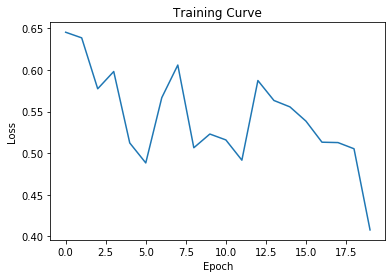

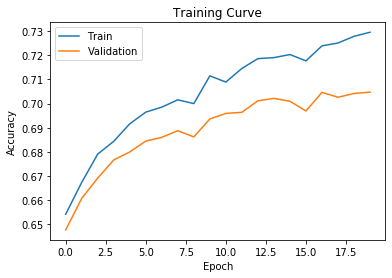

In [0]:
model = TweetRNN(50, 50, 2)
train_loader = TweetBatcher(train, batch_size=64, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=64, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=2e-4)

Epoch 1; Loss 0.506754; Train Acc 0.678621; Val Acc 0.671006
Epoch 2; Loss 0.552548; Train Acc 0.690873; Val Acc 0.679439
Epoch 3; Loss 0.545973; Train Acc 0.712449; Val Acc 0.700431
Epoch 4; Loss 0.651609; Train Acc 0.711144; Val Acc 0.688056
Epoch 5; Loss 0.593474; Train Acc 0.730970; Val Acc 0.710148
Epoch 6; Loss 0.602067; Train Acc 0.738830; Val Acc 0.710148
Epoch 7; Loss 0.416540; Train Acc 0.746086; Val Acc 0.715739
Epoch 8; Loss 0.398775; Train Acc 0.755569; Val Acc 0.717939
Epoch 9; Loss 0.514643; Train Acc 0.761011; Val Acc 0.722798
Epoch 10; Loss 0.517437; Train Acc 0.766834; Val Acc 0.717114
Epoch 11; Loss 0.364879; Train Acc 0.779595; Val Acc 0.716564
Epoch 12; Loss 0.482950; Train Acc 0.786596; Val Acc 0.716014
Epoch 13; Loss 0.517752; Train Acc 0.794870; Val Acc 0.710698
Epoch 14; Loss 0.288904; Train Acc 0.810591; Val Acc 0.710423
Epoch 15; Loss 0.358491; Train Acc 0.825547; Val Acc 0.709048
Epoch 16; Loss 0.475407; Train Acc 0.844068; Val Acc 0.700614
Epoch 17; Loss 0.

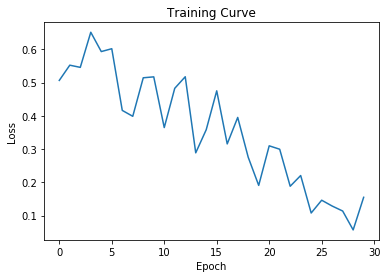

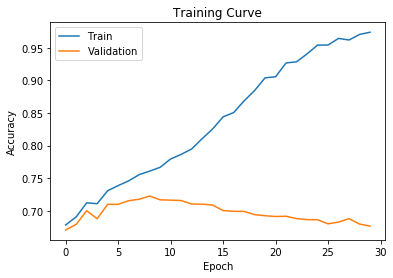

In [0]:
model = TweetRNN(50, 150, 2)
train_loader = TweetBatcher(train, batch_size=64, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=64, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=30, learning_rate=0.0007)

Epoch 1; Loss 0.658423; Train Acc 0.670538; Val Acc 0.665964
Epoch 2; Loss 0.563994; Train Acc 0.690269; Val Acc 0.679989
Epoch 3; Loss 0.642857; Train Acc 0.690746; Val Acc 0.683014
Epoch 4; Loss 0.600860; Train Acc 0.710062; Val Acc 0.694839
Epoch 5; Loss 0.630727; Train Acc 0.713595; Val Acc 0.697956
Epoch 6; Loss 0.624076; Train Acc 0.720023; Val Acc 0.703456
Epoch 7; Loss 0.557484; Train Acc 0.723110; Val Acc 0.704189
Epoch 8; Loss 0.498398; Train Acc 0.707612; Val Acc 0.691447
Epoch 9; Loss 0.550266; Train Acc 0.726928; Val Acc 0.705564
Epoch 10; Loss 0.650356; Train Acc 0.721614; Val Acc 0.702906
Epoch 11; Loss 0.566739; Train Acc 0.735075; Val Acc 0.710789
Epoch 12; Loss 0.494739; Train Acc 0.733707; Val Acc 0.708773
Epoch 13; Loss 0.673057; Train Acc 0.740962; Val Acc 0.712256
Epoch 14; Loss 0.538871; Train Acc 0.737239; Val Acc 0.709964
Epoch 15; Loss 0.516087; Train Acc 0.744526; Val Acc 0.712989
Epoch 16; Loss 0.438010; Train Acc 0.749236; Val Acc 0.715556
Epoch 17; Loss 0.

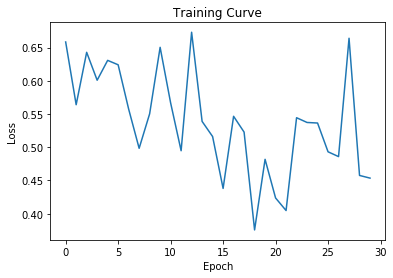

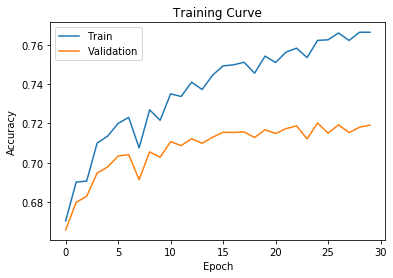

In [0]:
model = TweetRNN(50, 20, 2)
train_loader = TweetBatcher(train, batch_size=64, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=64, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=30, learning_rate=0.0007)

Epoch 1; Loss 0.576580; Train Acc 0.682949; Val Acc 0.675956
Epoch 2; Loss 0.555536; Train Acc 0.701216; Val Acc 0.690439
Epoch 3; Loss 0.582057; Train Acc 0.710922; Val Acc 0.700706
Epoch 4; Loss 0.508700; Train Acc 0.715504; Val Acc 0.696764
Epoch 5; Loss 0.560318; Train Acc 0.720341; Val Acc 0.703639
Epoch 6; Loss 0.524104; Train Acc 0.728488; Val Acc 0.709964
Epoch 7; Loss 0.471757; Train Acc 0.731829; Val Acc 0.711064
Epoch 8; Loss 0.574901; Train Acc 0.732943; Val Acc 0.715281
Epoch 9; Loss 0.495673; Train Acc 0.736825; Val Acc 0.717848
Epoch 10; Loss 0.472007; Train Acc 0.732720; Val Acc 0.705656
Epoch 11; Loss 0.475419; Train Acc 0.742235; Val Acc 0.709873
Epoch 12; Loss 0.550570; Train Acc 0.734598; Val Acc 0.705473
Epoch 13; Loss 0.544072; Train Acc 0.748727; Val Acc 0.716656
Epoch 14; Loss 0.477763; Train Acc 0.752100; Val Acc 0.719223
Epoch 15; Loss 0.545033; Train Acc 0.752673; Val Acc 0.717298
Epoch 16; Loss 0.524652; Train Acc 0.736507; Val Acc 0.707306
Epoch 17; Loss 0.

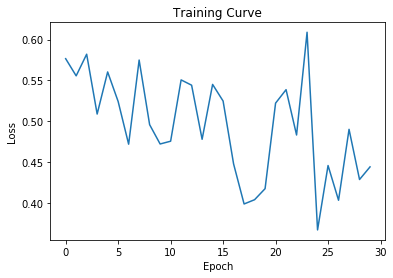

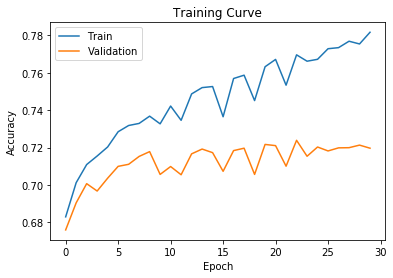

In [0]:
model = TweetRNN(50, 20, 2)
train_loader = TweetBatcher(train, batch_size=64, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=64, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=30, learning_rate=0.001)

Epoch 1; Loss 0.686217; Train Acc 0.552807; Val Acc 0.553855
Epoch 2; Loss 0.635311; Train Acc 0.628772; Val Acc 0.630030
Epoch 3; Loss 0.613035; Train Acc 0.659868; Val Acc 0.653864
Epoch 4; Loss 0.603928; Train Acc 0.661974; Val Acc 0.653497
Epoch 5; Loss 0.577419; Train Acc 0.672149; Val Acc 0.666147
Epoch 6; Loss 0.564407; Train Acc 0.682456; Val Acc 0.668256
Epoch 7; Loss 0.592808; Train Acc 0.687018; Val Acc 0.671281
Epoch 8; Loss 0.582392; Train Acc 0.690877; Val Acc 0.675864
Epoch 9; Loss 0.575002; Train Acc 0.682982; Val Acc 0.675406
Epoch 10; Loss 0.584414; Train Acc 0.697193; Val Acc 0.685489
Epoch 11; Loss 0.607491; Train Acc 0.693816; Val Acc 0.683839
Epoch 12; Loss 0.540743; Train Acc 0.703728; Val Acc 0.688881
Epoch 13; Loss 0.546765; Train Acc 0.696798; Val Acc 0.676506
Epoch 14; Loss 0.585084; Train Acc 0.706316; Val Acc 0.688881
Epoch 15; Loss 0.538120; Train Acc 0.702939; Val Acc 0.683197
Epoch 16; Loss 0.527792; Train Acc 0.714781; Val Acc 0.697039
Epoch 17; Loss 0.

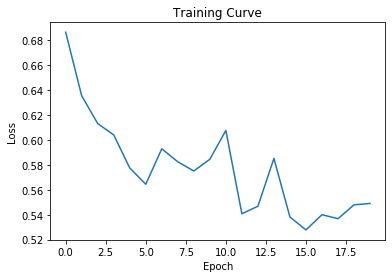

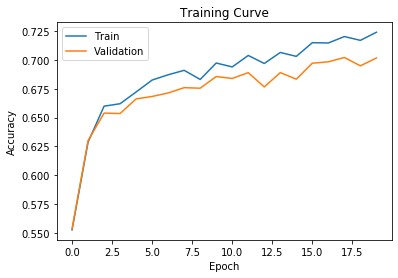

In [0]:
model = TweetRNN(50, 20, 2)
train_loader = TweetBatcher(train, batch_size=600, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=600, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=0.001)

Epoch 1; Loss 0.644256; Train Acc 0.638816; Val Acc 0.638830
Epoch 2; Loss 0.602911; Train Acc 0.662237; Val Acc 0.658722
Epoch 3; Loss 0.613470; Train Acc 0.671096; Val Acc 0.665964
Epoch 4; Loss 0.617199; Train Acc 0.676491; Val Acc 0.668806
Epoch 5; Loss 0.593200; Train Acc 0.686667; Val Acc 0.673389
Epoch 6; Loss 0.594281; Train Acc 0.688421; Val Acc 0.676597
Epoch 7; Loss 0.595020; Train Acc 0.682149; Val Acc 0.669906
Epoch 8; Loss 0.575503; Train Acc 0.692105; Val Acc 0.680722
Epoch 9; Loss 0.574035; Train Acc 0.699912; Val Acc 0.687322
Epoch 10; Loss 0.581254; Train Acc 0.706491; Val Acc 0.691631
Epoch 11; Loss 0.556889; Train Acc 0.702675; Val Acc 0.688056
Epoch 12; Loss 0.576624; Train Acc 0.708684; Val Acc 0.699147
Epoch 13; Loss 0.565599; Train Acc 0.713640; Val Acc 0.698231
Epoch 14; Loss 0.620587; Train Acc 0.706404; Val Acc 0.694931
Epoch 15; Loss 0.560934; Train Acc 0.714079; Val Acc 0.702814
Epoch 16; Loss 0.571571; Train Acc 0.722193; Val Acc 0.702723
Epoch 17; Loss 0.

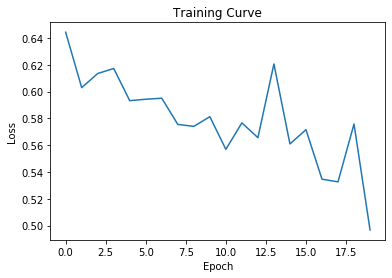

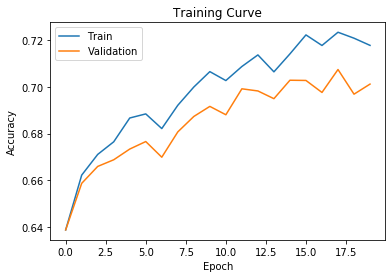

In [0]:
model = TweetRNN(50, 50, 2)
train_loader = TweetBatcher(train, batch_size=600, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=600, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=0.001)

Epoch 1; Loss 0.582580; Train Acc 0.676316; Val Acc 0.666514
Epoch 2; Loss 0.548338; Train Acc 0.664868; Val Acc 0.649555
Epoch 3; Loss 0.569535; Train Acc 0.717632; Val Acc 0.702356
Epoch 4; Loss 0.519121; Train Acc 0.724254; Val Acc 0.696947
Epoch 5; Loss 0.508999; Train Acc 0.733421; Val Acc 0.708314
Epoch 6; Loss 0.500300; Train Acc 0.744518; Val Acc 0.707764
Epoch 7; Loss 0.544551; Train Acc 0.757500; Val Acc 0.717939
Epoch 8; Loss 0.542068; Train Acc 0.752237; Val Acc 0.698597
Epoch 9; Loss 0.478900; Train Acc 0.774781; Val Acc 0.714181
Epoch 10; Loss 0.503505; Train Acc 0.778860; Val Acc 0.710239
Epoch 11; Loss 0.416665; Train Acc 0.794737; Val Acc 0.712989
Epoch 12; Loss 0.479177; Train Acc 0.804868; Val Acc 0.712439
Epoch 13; Loss 0.422685; Train Acc 0.806667; Val Acc 0.713356
Epoch 14; Loss 0.443328; Train Acc 0.821404; Val Acc 0.710056
Epoch 15; Loss 0.418169; Train Acc 0.821579; Val Acc 0.701806
Epoch 16; Loss 0.448837; Train Acc 0.828728; Val Acc 0.699331
Epoch 17; Loss 0.

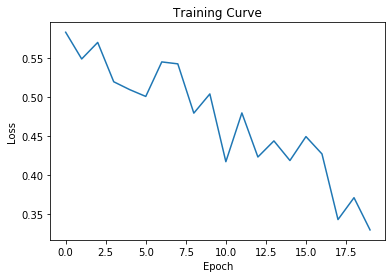

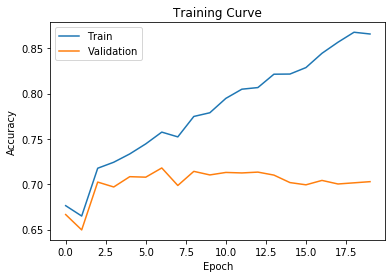

In [0]:
model = TweetRNN(50, 50, 2)
train_loader = TweetBatcher(train, batch_size=600, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=600, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=0.01)

Epoch 1; Loss 0.694682; Train Acc 0.608833; Val Acc 0.600788
Epoch 2; Loss 0.640626; Train Acc 0.663333; Val Acc 0.655789
Epoch 3; Loss 0.610089; Train Acc 0.672333; Val Acc 0.667981
Epoch 4; Loss 0.606061; Train Acc 0.690889; Val Acc 0.682464
Epoch 5; Loss 0.552636; Train Acc 0.702444; Val Acc 0.683381
Epoch 6; Loss 0.589752; Train Acc 0.704833; Val Acc 0.691906
Epoch 7; Loss 0.551488; Train Acc 0.714667; Val Acc 0.696214
Epoch 8; Loss 0.534500; Train Acc 0.728333; Val Acc 0.704648
Epoch 9; Loss 0.555767; Train Acc 0.734944; Val Acc 0.705564
Epoch 10; Loss 0.515326; Train Acc 0.735333; Val Acc 0.709048
Epoch 11; Loss 0.556725; Train Acc 0.743056; Val Acc 0.705748
Epoch 12; Loss 0.502241; Train Acc 0.754500; Val Acc 0.711981
Epoch 13; Loss 0.497140; Train Acc 0.756500; Val Acc 0.711431
Epoch 14; Loss 0.499411; Train Acc 0.772722; Val Acc 0.709139
Epoch 15; Loss 0.504710; Train Acc 0.753389; Val Acc 0.709506
Epoch 16; Loss 0.502139; Train Acc 0.774667; Val Acc 0.710789
Epoch 17; Loss 0.

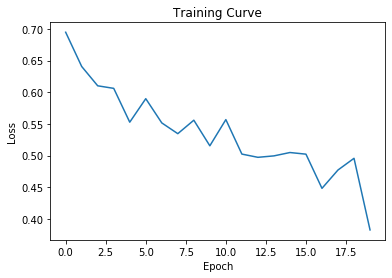

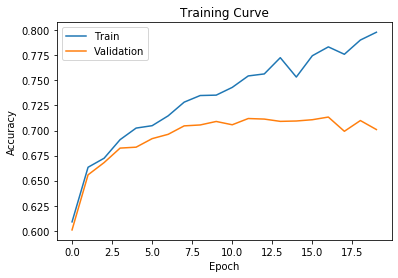

In [0]:
model = TweetRNN(50, 50, 2)
train_loader = TweetBatcher(train, batch_size=1000, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=1000, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=0.01)

In [0]:
class TweetRNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetRNN_GRU, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)#nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # Pass the output of the last time step to the classifier
        out = self.fc(out[:, -1, :])
        return out

Epoch 1; Loss 0.674614; Train Acc 0.612112; Val Acc 0.618297
Epoch 2; Loss 0.608154; Train Acc 0.660260; Val Acc 0.660922
Epoch 3; Loss 0.558074; Train Acc 0.668852; Val Acc 0.662756
Epoch 4; Loss 0.529788; Train Acc 0.677221; Val Acc 0.674764
Epoch 5; Loss 0.571735; Train Acc 0.680149; Val Acc 0.677514
Epoch 6; Loss 0.582161; Train Acc 0.685145; Val Acc 0.681272
Epoch 7; Loss 0.580554; Train Acc 0.690778; Val Acc 0.680264
Epoch 8; Loss 0.654896; Train Acc 0.691414; Val Acc 0.685489
Epoch 9; Loss 0.522211; Train Acc 0.689123; Val Acc 0.685856
Epoch 10; Loss 0.512333; Train Acc 0.695456; Val Acc 0.690439
Epoch 11; Loss 0.557462; Train Acc 0.699306; Val Acc 0.690072
Epoch 12; Loss 0.653132; Train Acc 0.701534; Val Acc 0.689981
Epoch 13; Loss 0.611280; Train Acc 0.703666; Val Acc 0.692272
Epoch 14; Loss 0.509502; Train Acc 0.703952; Val Acc 0.697681
Epoch 15; Loss 0.557577; Train Acc 0.705989; Val Acc 0.698597
Epoch 16; Loss 0.529834; Train Acc 0.708758; Val Acc 0.698506
Epoch 17; Loss 0.

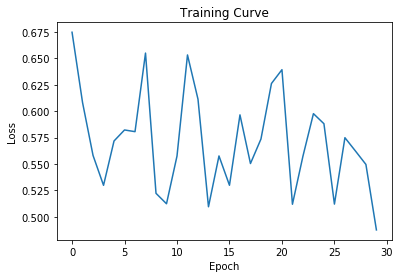

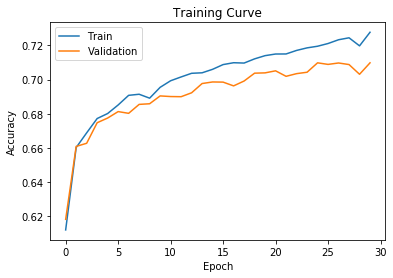

In [0]:
model = TweetRNN_GRU(50, 50, 2)
train_loader = TweetBatcher(train, batch_size=64, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=64, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=30, learning_rate=0.0001)

Epoch 1; Loss 0.693312; Train Acc 0.493317; Val Acc 0.496196
Epoch 2; Loss 0.688495; Train Acc 0.512506; Val Acc 0.514896
Epoch 3; Loss 0.693944; Train Acc 0.531186; Val Acc 0.533413
Epoch 4; Loss 0.683789; Train Acc 0.551076; Val Acc 0.553671
Epoch 5; Loss 0.686451; Train Acc 0.568705; Val Acc 0.570630
Epoch 6; Loss 0.686743; Train Acc 0.586272; Val Acc 0.588963
Epoch 7; Loss 0.698292; Train Acc 0.599955; Val Acc 0.600697
Epoch 8; Loss 0.671691; Train Acc 0.609439; Val Acc 0.613347
Epoch 9; Loss 0.665961; Train Acc 0.616376; Val Acc 0.619030
Epoch 10; Loss 0.670620; Train Acc 0.619749; Val Acc 0.620589
Epoch 11; Loss 0.649027; Train Acc 0.625796; Val Acc 0.628564
Epoch 12; Loss 0.653863; Train Acc 0.629837; Val Acc 0.631680
Epoch 13; Loss 0.644186; Train Acc 0.633019; Val Acc 0.636264
Epoch 14; Loss 0.622626; Train Acc 0.638270; Val Acc 0.642222
Epoch 15; Loss 0.611799; Train Acc 0.645653; Val Acc 0.649280
Epoch 16; Loss 0.644399; Train Acc 0.649949; Val Acc 0.653680
Epoch 17; Loss 0.

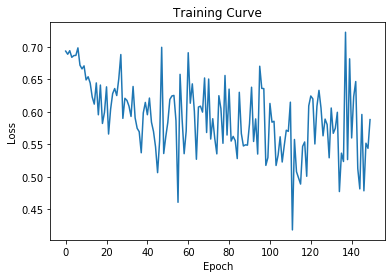

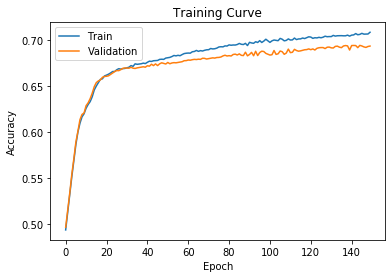

In [0]:
model = TweetRNN_GRU(50, 50, 2)
train_loader = TweetBatcher(train, batch_size=64, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=64, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=150, learning_rate=0.00001)

Epoch 1; Loss 0.680529; Train Acc 0.600051; Val Acc 0.600880
Epoch 2; Loss 0.642833; Train Acc 0.625064; Val Acc 0.628014
Epoch 3; Loss 0.616992; Train Acc 0.662010; Val Acc 0.662022
Epoch 4; Loss 0.552292; Train Acc 0.673784; Val Acc 0.668714
Epoch 5; Loss 0.562533; Train Acc 0.679099; Val Acc 0.674397
Epoch 6; Loss 0.619328; Train Acc 0.683395; Val Acc 0.677147
Epoch 7; Loss 0.559669; Train Acc 0.685654; Val Acc 0.676964
Epoch 8; Loss 0.561388; Train Acc 0.686895; Val Acc 0.677606
Epoch 9; Loss 0.596194; Train Acc 0.690969; Val Acc 0.679714
Epoch 10; Loss 0.583671; Train Acc 0.690619; Val Acc 0.677239
Epoch 11; Loss 0.532629; Train Acc 0.695583; Val Acc 0.682097
Epoch 12; Loss 0.548743; Train Acc 0.697842; Val Acc 0.683747
Epoch 13; Loss 0.592906; Train Acc 0.698543; Val Acc 0.683839
Epoch 14; Loss 0.570163; Train Acc 0.700356; Val Acc 0.686131
Epoch 15; Loss 0.571155; Train Acc 0.701120; Val Acc 0.686864
Epoch 16; Loss 0.506414; Train Acc 0.700993; Val Acc 0.687964
Epoch 17; Loss 0.

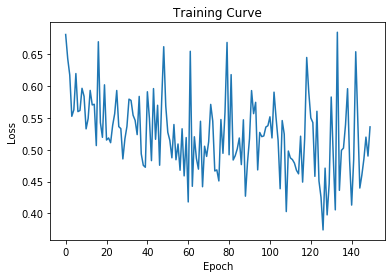

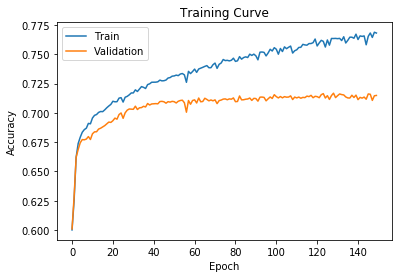

In [0]:
model = TweetRNN_GRU(50, 50, 2)
train_loader = TweetBatcher(train, batch_size=64, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=64, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=150, learning_rate=0.00007)

Epoch 1; Loss 0.667599; Train Acc 0.583821; Val Acc 0.580163
Epoch 2; Loss 0.655993; Train Acc 0.650013; Val Acc 0.650564
Epoch 3; Loss 0.602008; Train Acc 0.665288; Val Acc 0.660556
Epoch 4; Loss 0.591057; Train Acc 0.670538; Val Acc 0.663214
Epoch 5; Loss 0.565448; Train Acc 0.668374; Val Acc 0.661381
Epoch 6; Loss 0.623423; Train Acc 0.677062; Val Acc 0.668439
Epoch 7; Loss 0.647138; Train Acc 0.679290; Val Acc 0.672014
Epoch 8; Loss 0.697998; Train Acc 0.682217; Val Acc 0.672747
Epoch 9; Loss 0.596477; Train Acc 0.682090; Val Acc 0.676689
Epoch 10; Loss 0.613072; Train Acc 0.686100; Val Acc 0.674214
Epoch 11; Loss 0.542930; Train Acc 0.688041; Val Acc 0.677789
Epoch 12; Loss 0.514205; Train Acc 0.689791; Val Acc 0.678614
Epoch 13; Loss 0.511587; Train Acc 0.691510; Val Acc 0.678064
Epoch 14; Loss 0.673688; Train Acc 0.680499; Val Acc 0.671281
Epoch 15; Loss 0.531041; Train Acc 0.694883; Val Acc 0.679897
Epoch 16; Loss 0.546600; Train Acc 0.697110; Val Acc 0.681456
Epoch 17; Loss 0.

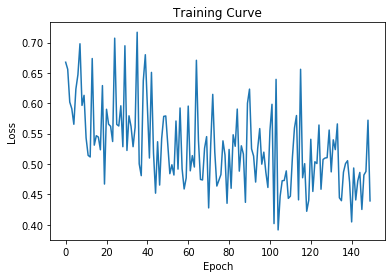

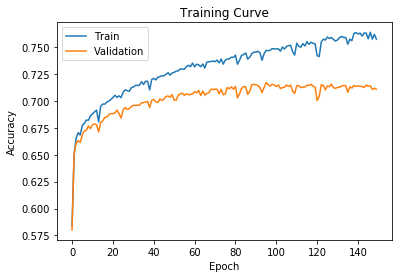

In [0]:
model = TweetRNN(50, 50, 2)#lstm
train_loader = TweetBatcher(train, batch_size=64, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=64, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=150, learning_rate=0.00007)

Epoch 1; Loss 0.643205; Train Acc 0.633465; Val Acc 0.626914
Epoch 2; Loss 0.565613; Train Acc 0.688684; Val Acc 0.677331
Epoch 3; Loss 0.573333; Train Acc 0.670088; Val Acc 0.656430
Epoch 4; Loss 0.548581; Train Acc 0.714035; Val Acc 0.700156
Epoch 5; Loss 0.536565; Train Acc 0.725307; Val Acc 0.704006
Epoch 6; Loss 0.504205; Train Acc 0.738465; Val Acc 0.706298
Epoch 7; Loss 0.506280; Train Acc 0.748772; Val Acc 0.716931
Epoch 8; Loss 0.504741; Train Acc 0.754605; Val Acc 0.708956
Epoch 9; Loss 0.464613; Train Acc 0.770526; Val Acc 0.715373
Epoch 10; Loss 0.491181; Train Acc 0.773947; Val Acc 0.714731
Epoch 11; Loss 0.458532; Train Acc 0.791754; Val Acc 0.720414
Epoch 12; Loss 0.480713; Train Acc 0.780570; Val Acc 0.706298
Epoch 13; Loss 0.471940; Train Acc 0.805000; Val Acc 0.714548
Epoch 14; Loss 0.389536; Train Acc 0.819561; Val Acc 0.718123
Epoch 15; Loss 0.429500; Train Acc 0.825132; Val Acc 0.712348
Epoch 16; Loss 0.384349; Train Acc 0.827675; Val Acc 0.706298
Epoch 17; Loss 0.

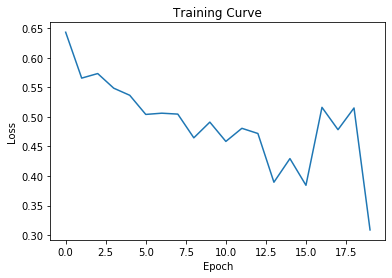

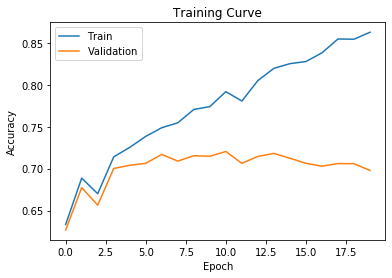

In [0]:
model = TweetRNN(50, 50, 2)#lstm
train_loader = TweetBatcher(train, batch_size=600, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=600, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=20, learning_rate=0.01)

Epoch 1; Loss 0.635213; Train Acc 0.612018; Val Acc 0.610688
Epoch 2; Loss 0.587576; Train Acc 0.666272; Val Acc 0.655239
Epoch 3; Loss 0.550248; Train Acc 0.710702; Val Acc 0.697406
Epoch 4; Loss 0.553705; Train Acc 0.722061; Val Acc 0.703914
Epoch 5; Loss 0.533683; Train Acc 0.729693; Val Acc 0.706756
Epoch 6; Loss 0.503626; Train Acc 0.744737; Val Acc 0.711614
Epoch 7; Loss 0.497734; Train Acc 0.754298; Val Acc 0.712348


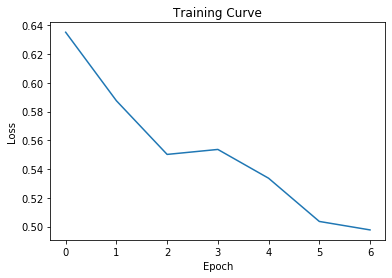

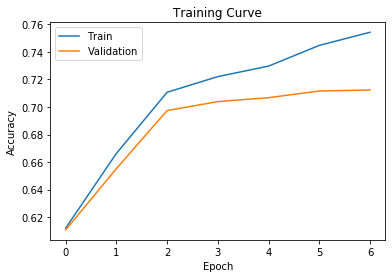

In [0]:
model = TweetRNN(50, 50, 2)#lstm
train_loader = TweetBatcher(train, batch_size=600, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=600, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=7, learning_rate=0.01)

Epoch 1; Loss 0.607209; Train Acc 0.659167; Val Acc 0.653130
Epoch 2; Loss 0.587350; Train Acc 0.679035; Val Acc 0.668806
Epoch 3; Loss 0.570142; Train Acc 0.711447; Val Acc 0.694381
Epoch 4; Loss 0.558854; Train Acc 0.714605; Val Acc 0.690531
Epoch 5; Loss 0.512091; Train Acc 0.728991; Val Acc 0.702631
Epoch 6; Loss 0.500235; Train Acc 0.731447; Val Acc 0.706664
Epoch 7; Loss 0.473982; Train Acc 0.747719; Val Acc 0.707123


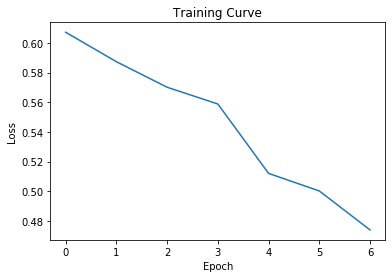

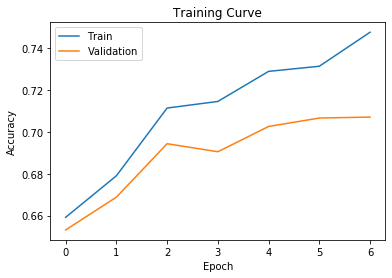

In [0]:
model = TweetRNN(50, 50, 2)#lstm
train_loader = TweetBatcher(train, batch_size=600, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=600, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=7, learning_rate=0.01)

In [0]:
def get_new_tweet(glove_vector, sample_tweet):
    tweet = sample_tweet
    idxs = [glove_vector.stoi[w]        # lookup the index of word
            for w in split_tweet(tweet)
            if w in glove_vector.stoi] # keep words that has an embedding
    idxs = torch.tensor(idxs) # convert list to pytorch tensor
    return idxs

In [0]:
new_tweet = get_new_tweet(glove, "This is a terrible tragedy")
print(new_tweet.shape)

out = torch.sigmoid(model(new_tweet.unsqueeze(0)))
pred = out.max(1, keepdim=True)[1]
print(pred)

torch.Size([5])
tensor([[0]])


In [0]:
new_tweet = get_new_tweet(glove, "")
print(new_tweet.shape)

out = torch.sigmoid(model(new_tweet.unsqueeze(0)))
pred = out.max(1, keepdim=True)[1]
print(pred)

torch.Size([0])


RuntimeError: ignored

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create feature vectors
vectorizer = TfidfVectorizer(sublinear_tf = True,
                             use_idf = True)
train_vectors = vectorizer.fit_transform(df_train['text'])
test_vectors = vectorizer.transform(df_test['text'])

In [0]:
import time
from sklearn import svm
from sklearn.metrics import classification_report
# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
t0 = time.time()
print(df_train['label'])
classifier_linear.fit(train_vectors, df_train['label'])
t1 = time.time()
prediction_linear = classifier_linear.predict(test_vectors)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1
# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(df_test['label'], prediction_linear, output_dict=True)
print('positive: ', report['pos'])
print('negative: ', report['neg'])

0        neg
1        neg
2        neg
3        neg
4        neg
        ... 
32701    pos
32702    pos
32703    pos
32704    pos
32705    pos
Name: label, Length: 32706, dtype: object
Training time: 246.628333s; Prediction time: 29.677907s
positive:  {'precision': 0.7734579439252336, 'recall': 0.7624838769117376, 'f1-score': 0.767931706411803, 'support': 5427}
negative:  {'precision': 0.767956795679568, 'recall': 0.778751369112815, 'f1-score': 0.7733164143931841, 'support': 5478}


In [0]:
test_loader = TweetBatcher(test, batch_size=600, drop_last=False)

In [0]:
test_accuracy = get_accuracy(model, test_loader)
print(test_accuracy)

0.7147180192572214
